In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from src.visualization.scalers import draw_scaler
from src.visualization.correlation import corr_matrix, spearman

import warnings

warnings.filterwarnings("ignore")

# Get processed dataset

In [9]:
df = pd.read_csv("../data/interim/spb_house_with_subway.csv")
df.head(5)

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,sqm_price,year,month,level_to_levels,area_to_rooms,StationName,SubwayDistance
0,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1,115755.627010,2018,3,0.400000,31.1,Международная,1078.709945
1,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1,103225.806452,2018,4,0.777778,31.0,Проспект Ветеранов,3233.926980
2,7100000,60.011172,30.243795,3,7,12,3,69.0,11.0,1,102898.550725,2018,5,0.583333,23.0,Комендантский проспект,711.612253
3,8500000,59.849104,30.314112,3,14,14,2,60.0,11.0,1,141666.666667,2018,5,1.000000,30.0,Московская,527.894148
4,3830000,59.981490,30.371730,2,2,17,1,44.9,16.5,11,85300.668151,2018,6,0.117647,44.9,Лесная,1555.289807


In [10]:
df.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,sqm_price,year,month,level_to_levels,area_to_rooms,SubwayDistance
count,4.262530e+05,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000,426253.000000
mean,7.335302e+06,59.934175,30.319312,1.940986,7.696901,14.615719,1.800898,56.296296,11.630735,5.240510,128271.699163,2019.551942,6.525561,0.541145,32.476082,2572.813384
std,4.565207e+06,0.084038,0.119096,0.956586,5.751069,7.064051,0.970597,26.016039,5.123148,4.941987,33936.071496,0.845023,3.428126,0.282351,9.552891,3726.406626
min,1.520000e+06,59.647383,29.509349,0.000000,1.000000,1.000000,0.000000,20.000000,0.000000,1.000000,75000.000000,2018.000000,1.000000,0.032258,2.875000,3.013156
25%,4.500000e+06,59.863328,30.255340,1.000000,3.000000,9.000000,1.000000,37.400000,8.100000,1.000000,103381.642512,2019.000000,3.000000,0.300000,26.000000,749.684569
50%,5.950000e+06,59.939084,30.324374,2.000000,6.000000,14.000000,2.000000,50.000000,11.000000,1.000000,121951.219512,2020.000000,7.000000,0.533333,31.500000,1407.049399
75%,8.526098e+06,60.002421,30.397679,3.000000,11.000000,21.000000,2.000000,67.100000,14.680000,11.000000,145712.666667,2020.000000,10.000000,0.785714,37.400000,2994.609630
max,4.985000e+07,60.241984,30.711428,5.000000,35.000000,38.000000,9.000000,200.000000,29.960000,11.000000,250000.000000,2021.000000,12.000000,4.000000,198.000000,46469.507505


In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426253 entries, 0 to 426252
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   price            426253 non-null  int64  
 1   geo_lat          426253 non-null  float64
 2   geo_lon          426253 non-null  float64
 3   building_type    426253 non-null  int64  
 4   level            426253 non-null  int64  
 5   levels           426253 non-null  int64  
 6   rooms            426253 non-null  int64  
 7   area             426253 non-null  float64
 8   kitchen_area     426253 non-null  float64
 9   object_type      426253 non-null  int64  
 10  sqm_price        426253 non-null  float64
 11  year             426253 non-null  int64  
 12  month            426253 non-null  int64  
 13  level_to_levels  426253 non-null  float64
 14  area_to_rooms    426253 non-null  float64
 15  StationName      426253 non-null  object 
 16  SubwayDistance   426253 non-null  floa

# EDA

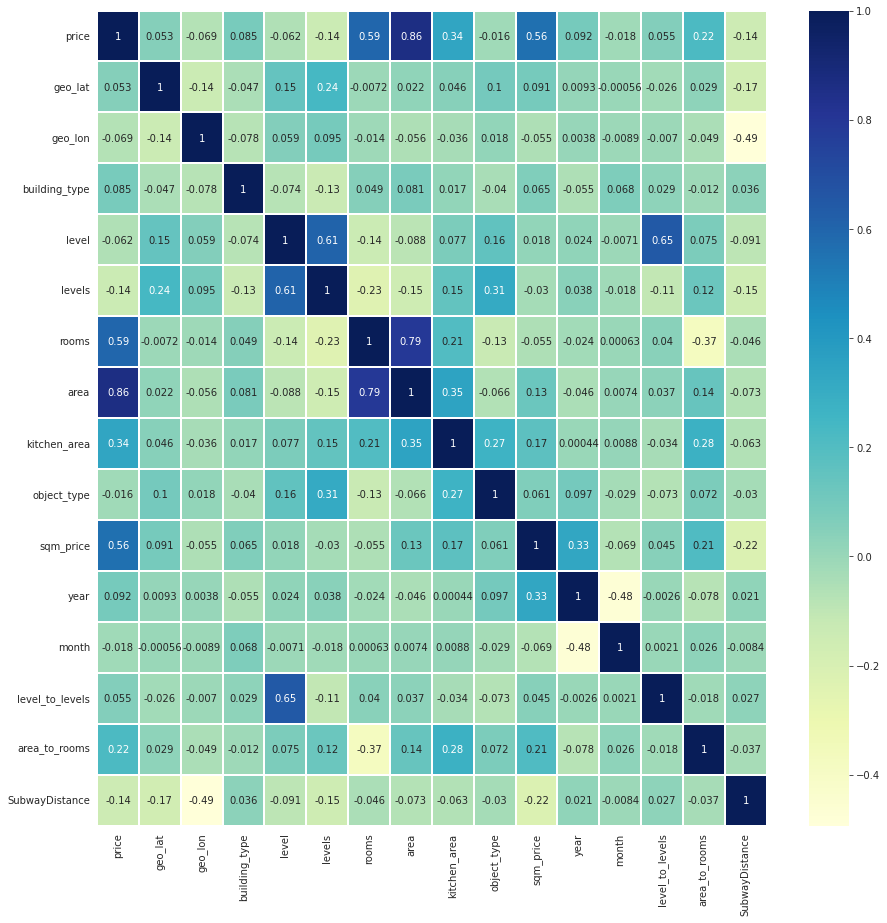

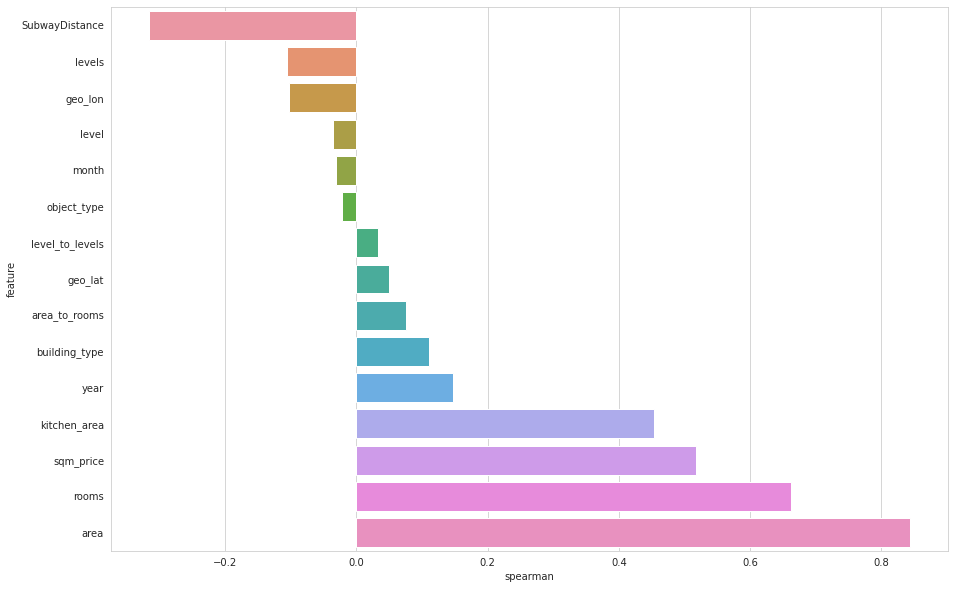

In [12]:
corrmat = corr_matrix(df)
spr = spearman(df, corrmat)

# Feature engineering

# Make Pipline


In [13]:
df = df.select_dtypes(exclude=["object"])
X_full, y_full = df.loc[:, df.columns != "price"], df["price"]

In [14]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full, y_full, random_state=0
)
XGBregressor = xgb.XGBRegressor
pipe = make_pipeline(RobustScaler(), XGBregressor(), verbose=True)
param_grid = {
    "xgbregressor__max_depth": [3, 5, 10],
    "xgbregressor__n_estimators": [10],
    "xgbregressor__learning_rate": [0.01, 0.1],
    "xgbregressor__lambda": [1, 2, 3],
    "xgbregressor__n_jobs": [-1],
}
grid = GridSearchCV(pipe, param_grid, scoring="r2", cv=5, n_jobs=-1)
grid.fit(X_trainval, y_trainval)

[Pipeline] ...... (step 1 of 2) Processing robustscaler, total=   0.2s
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   2.8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                     

In [15]:
# print(grid.best_estimator_)
print(f"Best parameters are {grid.best_params_}")
print(f"Score is {grid.score(X_trainval, y_trainval)}")
print(f"Score is {grid.score(X_test, y_test)}")

Best parameters are {'xgbregressor__lambda': 1, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 10, 'xgbregressor__n_jobs': -1}
Score is 0.5617471188440715
Score is 0.5580038602465709


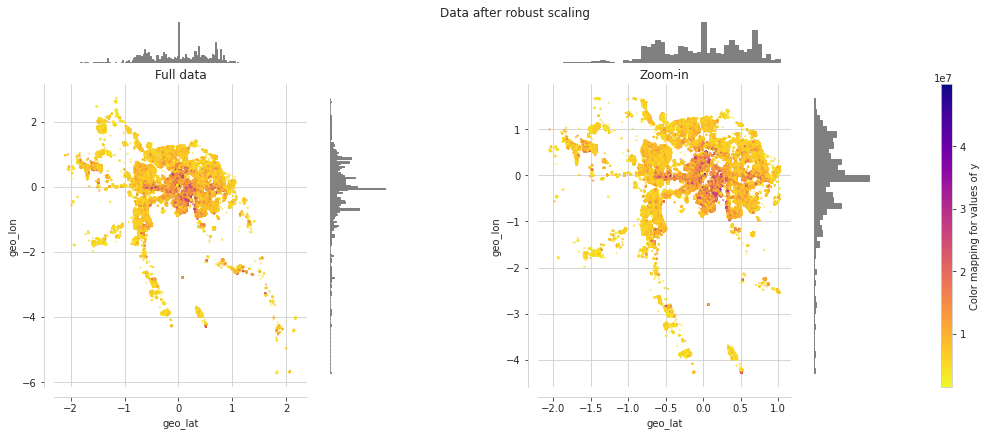

In [16]:
# take dictionary keys, 0-scaler index
scaler = [*grid.best_estimator_.named_steps][0]
# Take only 2 features to make visualization easier
features = ["geo_lat", "geo_lon"]
draw_scaler(X_full, y_full, features, scaler)
